Per funzionare, il presente notebook ha bisogno della cartella contenente i dati. <br> <br>
Dataset originale: <br>
https://github.com/vkaya24100/Different-Weapon-Types-datasets <br>
E' possibile importarli semplicemente aggiungendo una scorciatoia al proprio Drive per la seguente cartella: <br>
**https://drive.google.com/drive/folders/1m3muJ_peOKJkbCx-08ixRADQnrfaId0i?usp=sharing**

In [7]:
import pandas as pd
import numpy as np
import zipfile
import os
from google.colab import drive
from shutil import copyfile, rmtree
import random
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt

from scipy.io import wavfile as wav

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow import keras
from sklearn.metrics import confusion_matrix
import joblib
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from keras.preprocessing import image as kimage

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = [15,5]

### FUNZIONI

In [8]:
def name_to_number(input):
  labels = np.array(['Colt1911','WinM14','HKUSP','SpKing22','Ruger22','Glock45','M16','WASR','Ruger357','Glock92','Rem700','SW22','Kimber45','BoltAction22','MP402','SIG9','SW38SP','Glock91','Lorcin380','MP401'])
  return np.where(labels==input)[0][0]

In [9]:
def grafico(cf_matrix, name, labels):
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', square=True)

  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values');

  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

  plt.savefig(name, bbox_inches='tight', pad_inches=0.5)
  copyfile(name, f'gdrive/My Drive/Data_DigitalSignalsProject/sound_confusion_matrix/{name}')

### LETTURA DATI

In [4]:
drive.mount('/content/gdrive')
copyfile('gdrive/MyDrive/Data_DigitalSignalsProject/sound.zip', 'sound.zip')
zip = zipfile.ZipFile('sound.zip')
zip.extractall()

Mounted at /content/gdrive


In [5]:
os.mkdir('sound_organized')
os.mkdir('sound_organized/train')
os.mkdir('sound_organized/test')
total_cls = []
total_dev = []


for f in tqdm(os.listdir('sound')):
  cls = "".join(f.split('_')[:-1])
  if cls not in total_cls:
    total_cls.append(cls)
  dev = f.split('_')[-1]
  if dev not in total_dev:
    total_dev.append(dev)

  random.seed(123)
  train_idx = random.sample(range(len(os.listdir(f'sound/{f}'))), int(len(os.listdir(f'sound/{f}'))*0.8))

  for i,s in enumerate(os.listdir(f'sound/{f}')):
    if s[-4:]=='.wav':
      name = s.replace('_','')
      sound_rate, sound_data = wav.read(f'sound/{f}/{s}')
      if i in train_idx:
        wav.write(f'sound_organized/train/{cls}_{dev}_{name}', sound_rate, sound_data)
      else:
        wav.write(f'sound_organized/test/{cls}_{dev}_{name}', sound_rate, sound_data)



100%|██████████| 60/60 [00:11<00:00,  5.22it/s]


In [6]:
# Sono presenti alcuni file in cui per ogni istante temporale abbiamo 2 valori. Verifichiamo che in tutti questi casi i due valori coincidano, in modo da poter eliminare questa dimensionalità aggiuntiva inutile

for s in os.listdir('sound_organized/train'):
  sound_rate, sound_data = wav.read(f'sound_organized/train/{s}')
  if len(sound_data.shape)>1:
    if all(sound_data[:,0]-sound_data[:,1]==0)==False:
      print('_____ PROBLEM _____')
    else:
      sound_data  = sound_data[:,0]
      wav.write(f'sound_organized/train/{s}', sound_rate, sound_data)

for s in os.listdir('sound_organized/test'):
  sound_rate, sound_data = wav.read(f'sound_organized/test/{s}')
  if len(sound_data.shape)>1:
    if all(sound_data[:,0]-sound_data[:,1]==0)==False:
      print('_____ PROBLEM _____')
    else:
      sound_data  = sound_data[:,0]
      wav.write(f'sound_organized/test/{s}', sound_rate, sound_data)

In [ ]:
def energy(input):
  return np.sum((input*1.0)**2, keepdims=True)

def duration(input, rate):
  return np.array([input.shape[0] / rate])

def amplitude(input):
  return np.array([max([abs(x) for x in input])])

def zcr(input):
  prev = '-'
  count = 0
  for _ in input*1.0:
    if(prev=='-'): 
      prev=_
    else: 
      if(prev*_<0): 
        count+=1
      elif(prev!=0 and _==0): 
                            
        count+=1
      prev=_
  return np.array([count])

In [ ]:
sound_rate_array = []
duration_array = []
energy_array = []
amplitude_array = []
zcr_array = []

cls_array = []
dev_array = []

for s in tqdm(os.listdir('sound_organized/train')):
  sound_rate, sound_data = wav.read(f'sound_organized/train/{s}')

  sound_rate_array.append(sound_rate)
  duration_array.append(duration(sound_data, sound_rate)[0])
  energy_array.append(energy(sound_data)[0])
  amplitude_array.append(amplitude(sound_data)[0])
  zcr_array.append(zcr(sound_data)[0])

  cls_array.append(s.split('_')[0])
  dev_array.append(s.split('_')[1])

In [ ]:
data = pd.DataFrame()
data['cls'] = cls_array
data['dev'] = dev_array
data['sound_rate'] = sound_rate_array
data['duration'] = duration_array
data['energy'] = energy_array
data['amplitude'] = amplitude_array
data['zcr'] = zcr_array

#**ANALISI**

#### SOUND RATE

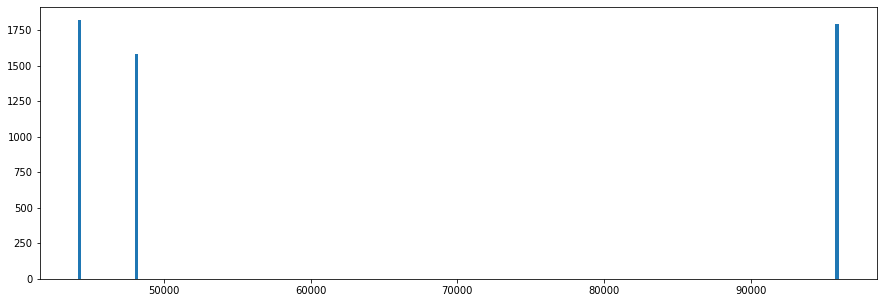

In [ ]:
plt.hist(data['sound_rate'], bins=200)
plt.show()

In [ ]:
len(set(data['sound_rate']))

3

In [ ]:
set(data[data['dev']=='Samsung']['sound_rate'])

{48000}

In [ ]:
set(data[data['dev']=='iPhone']['sound_rate'])

{44100}

In [ ]:
set(data[data['dev']=='Zoom']['sound_rate'])

{96000}

I diversi dispositivi registrano a sound rate diversi.

#### FEATURES NEI DIVERSI DISPOSITIVI

In [ ]:
dev_set = list(set(data['dev']))

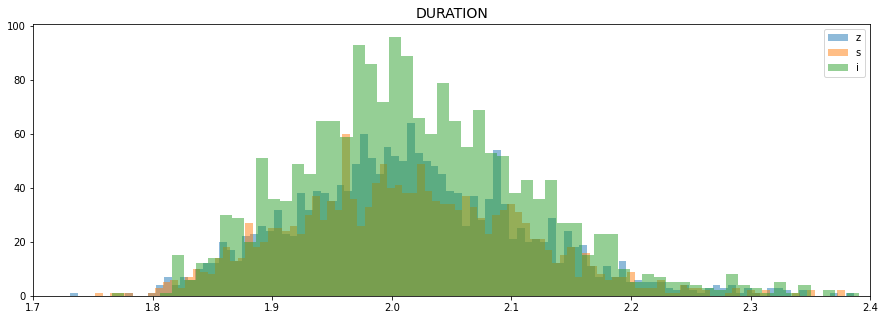

In [ ]:
plt.hist(data[data['dev']=='Zoom']['duration'], bins=100, label='z', alpha=0.5)
plt.hist(data[data['dev']=='Samsung']['duration'], bins=100, label='s', alpha=0.5)
plt.hist(data[data['dev']=='iPhone']['duration'], bins=100, label='i', alpha=0.5)
plt.title('DURATION', fontsize=14)
plt.legend(['z','s','i'])
plt.xlim(1.7,2.4)
plt.show()

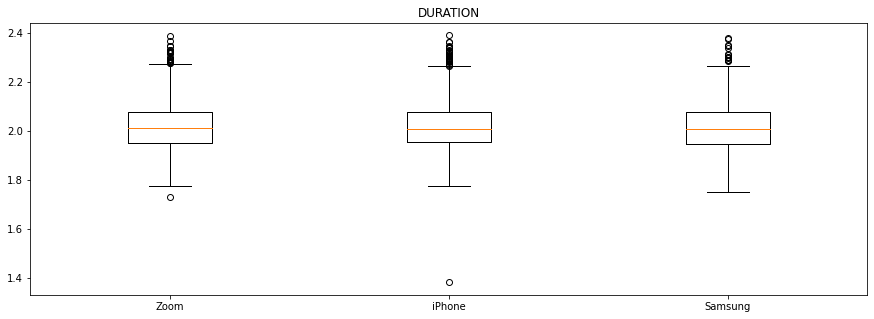

In [ ]:
my_dict = {}
for _ in dev_set:
  my_dict[_]=data[data['dev']==_]['duration']

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.title('DURATION')
plt.show()

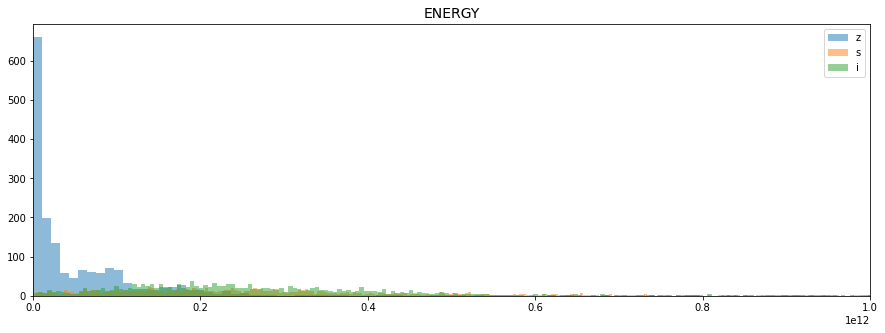

In [ ]:
plt.hist(data[data['dev']=='Zoom']['energy'], bins=1000, label='z', alpha=0.5)
plt.hist(data[data['dev']=='Samsung']['energy'], bins=1000, label='s', alpha=0.5)
plt.hist(data[data['dev']=='iPhone']['energy'], bins=1000, label='i', alpha=0.5)
plt.title('ENERGY', fontsize=14)
plt.legend(['z','s','i'])
plt.xlim(0,1000000000000)
plt.show()

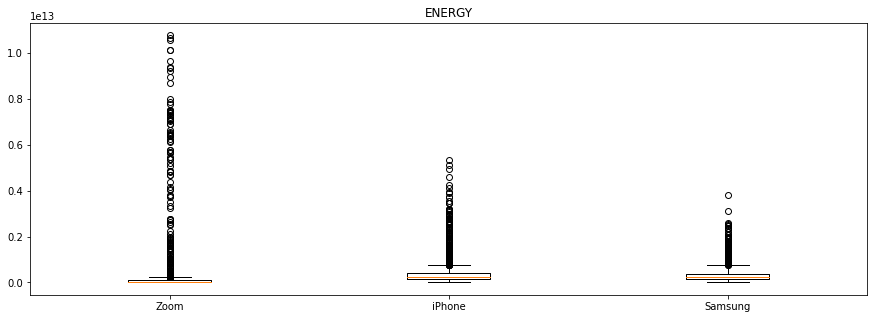

In [ ]:
my_dict = {}
for _ in dev_set:
  my_dict[_]=data[data['dev']==_]['energy']

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.title('ENERGY')
plt.show()

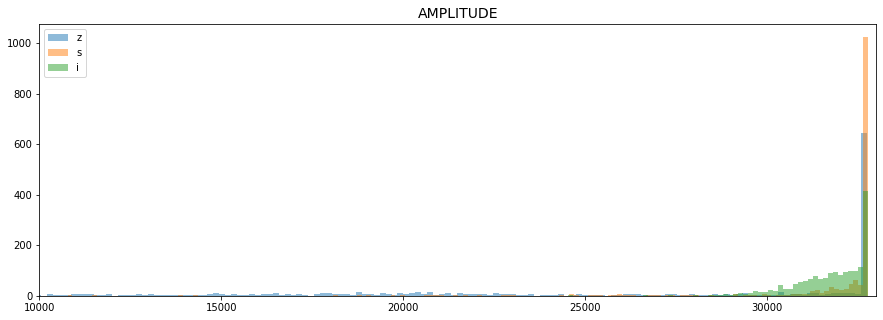

In [ ]:
plt.hist(data[data['dev']=='Zoom']['amplitude'], bins=200, label='z', alpha=0.5)
plt.hist(data[data['dev']=='Samsung']['amplitude'], bins=200, label='s', alpha=0.5)
plt.hist(data[data['dev']=='iPhone']['amplitude'], bins=200, label='i', alpha=0.5)
plt.title('AMPLITUDE', fontsize=14)
plt.legend(['z','s','i'])
plt.xlim(10000,33000)
plt.show()

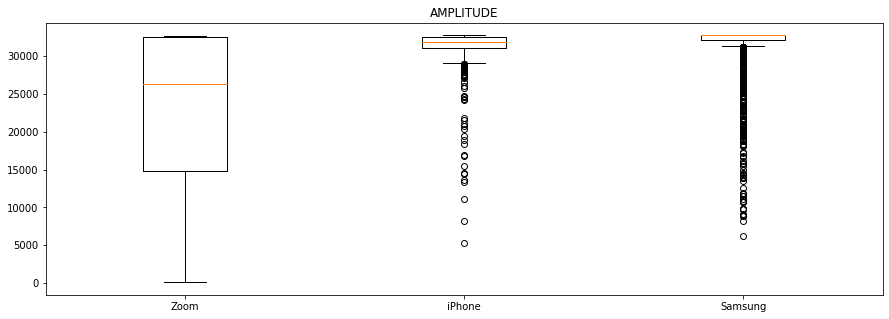

In [ ]:
my_dict = {}
for _ in dev_set:
  my_dict[_]=data[data['dev']==_]['amplitude']

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.title('AMPLITUDE')
plt.show()

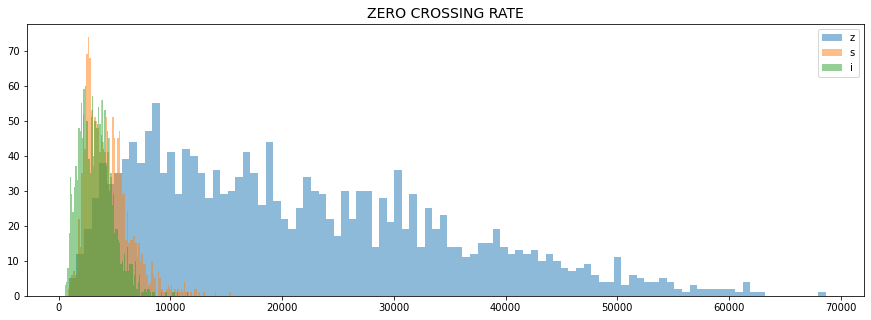

In [ ]:
plt.hist(data[data['dev']=='Zoom']['zcr'], bins=100, label='z', alpha=0.5)
plt.hist(data[data['dev']=='Samsung']['zcr'], bins=100, label='s', alpha=0.5)
plt.hist(data[data['dev']=='iPhone']['zcr'], bins=100, label='i', alpha=0.5)
plt.title('ZERO CROSSING RATE', fontsize=14)
plt.legend(['z','s','i'])
# plt.xlim(10000,33000)
plt.show()

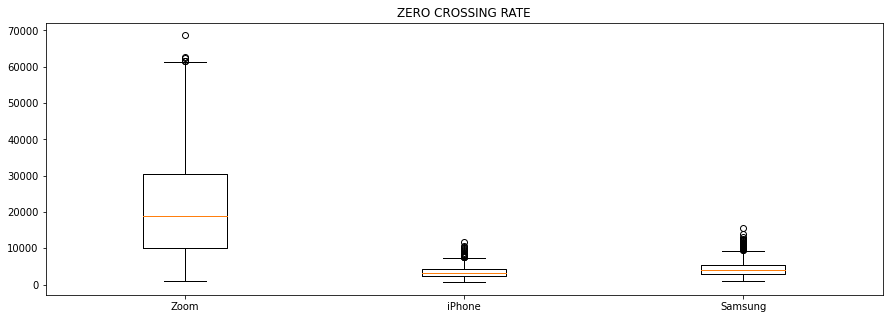

In [ ]:
my_dict = {}
for _ in dev_set:
  my_dict[_]=data[data['dev']==_]['zcr']

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.title('ZERO CROSSING RATE')
plt.show()

#### FEATURES NELLE DIVERSE CLASSI

In [ ]:
cls_set = list(set(data['cls']))


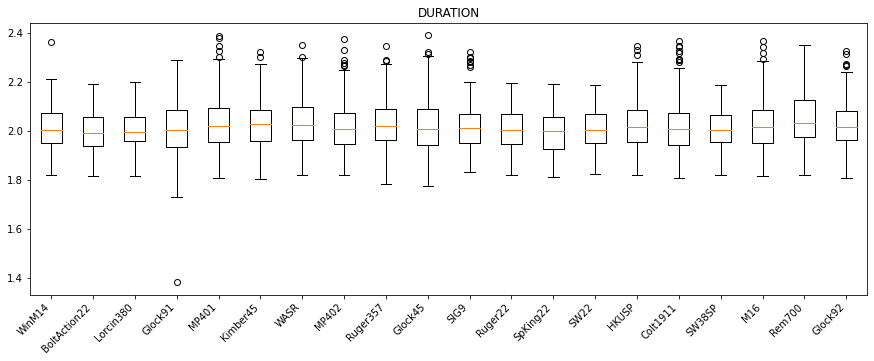

In [ ]:
my_dict = {}
for _ in cls_set:
  my_dict[_]=data[data['cls']==_]['duration']

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.xticks(rotation=45, ha='right')
plt.title('DURATION')
plt.show()

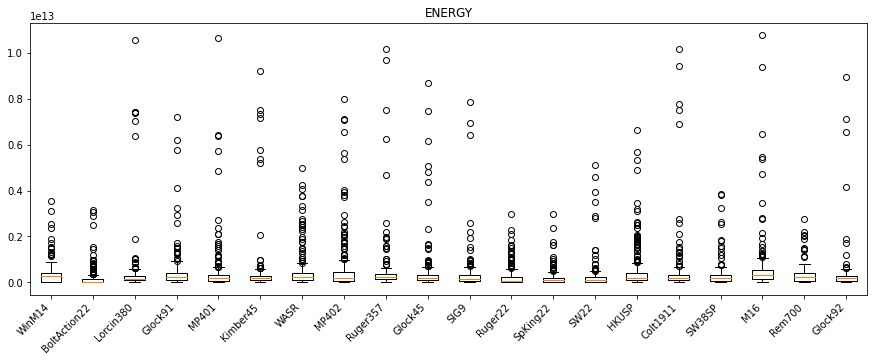

In [ ]:
my_dict = {}
for _ in cls_set:
  my_dict[_]=data[data['cls']==_]['energy']

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.xticks(rotation=45, ha='right')
plt.title('ENERGY')
plt.show()

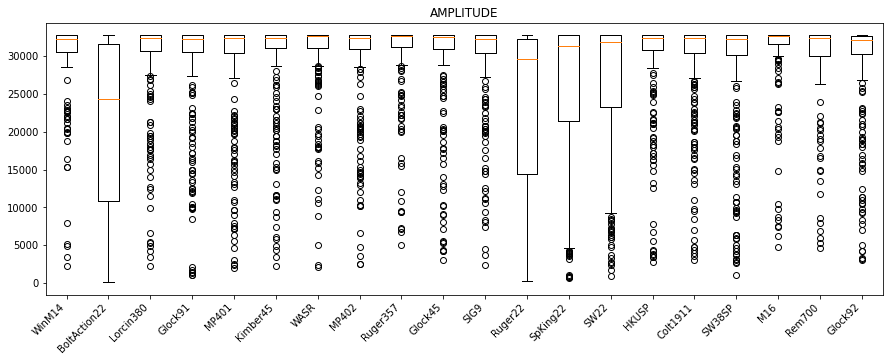

In [ ]:
my_dict = {}
for _ in cls_set:
  my_dict[_]=data[data['cls']==_]['amplitude']

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.xticks(rotation=45, ha='right')
plt.title('AMPLITUDE')
plt.show()

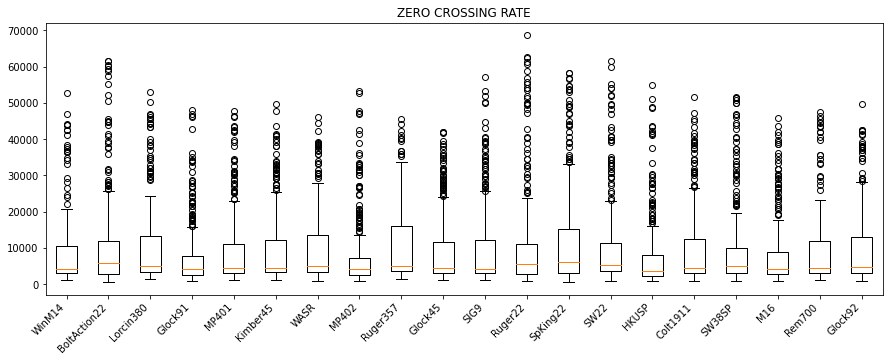

In [ ]:
my_dict = {}
for _ in cls_set:
  my_dict[_]=data[data['cls']==_]['zcr']

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.xticks(rotation=45, ha='right')
plt.title('ZERO CROSSING RATE')
plt.show()

**modelli da provare**
1. SVC
2. XGBoost
4. MLP

3. RNN e/o GRU






# **CLASSIFICAZIONE**

## ***FEATURE EXTRACTION***

In [11]:
def feats_spectrogram(input, rate=8000, tsize=400):
  [spec_freqs, spec_times, spec] = spectrogram(input, fs=rate)
  if len(input)<256: #se è minore di 256 otteniamo una matrice che ha meno righe del normale, in questo caso non riteniamo l'input adatto ad essere utilizzato
    ret=0 
  elif spec.shape[1]>(tsize-1):
    ret = spec[:,0:tsize]
  else:
    diff = tsize-spec.shape[1]
    z = np.zeros((diff, len(spec)))
    ret = np.concatenate((spec, z.T), axis=1)
  return ret.flatten()

def feats_mfcc(input, rate=8000, tsize=197, transposed=True):
  spec = mfcc(input*1.0, sr=rate)
  if spec.shape[1]>(tsize-1):
    ret = spec[:,0:tsize]
  else:
    diff = tsize-spec.shape[1]
    z = np.zeros((diff, len(spec)))
    ret = np.concatenate((spec, z.T), axis=1)
  if transposed:
    ret=ret.T
  return ret


def load_data(feature_extractor=feats_spectrogram, normalize=False, ts=0.1, tsize_=10):

    labels = []
    features = []

    for f in tqdm(os.listdir('sound_organized/train')):
        if f.endswith('.wav'):
            signal_rate, signal = wav.read('sound_organized/train/' + f)
            cur_features = feature_extractor(signal, rate = signal_rate, tsize=tsize_)
            features.append(cur_features)

            label = f.split('_')[0]
            labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=ts, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

## XGBOOST

#### SPECTROGRAM

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_spectrogram, normalize=True, tsize_=400)

100%|██████████| 5197/5197 [00:16<00:00, 316.03it/s]


In [ ]:
pca = PCA(n_components=500)
pca.fit(X_train)

print(sum(pca.explained_variance_ratio_))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

0.7577397687677728


In [ ]:
clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_depth=5, random_state=0, verbose=1)
clf.fit(X_train_pca, y_train)

      Iter       Train Loss   Remaining Time 
         1           2.8513            6.82m
         2           2.7697            6.43m
         3           2.6948            6.07m
         4           2.6355            5.72m
         5           2.5624            5.33m
         6           2.5009            4.96m
         7           2.4314            4.59m
         8           2.3617            4.22m
         9           2.2976            3.88m
        10           2.2258            3.51m
        20           1.5979            0.00s


GradientBoostingClassifier(max_depth=5, n_estimators=20, random_state=0,
                           verbose=1)

In [ ]:
y_pred_train = clf.predict(X_train_pca)
cm_spectrogram = confusion_matrix(y_train, y_pred_train)

y_pred = clf.predict(X_test_pca)
cm_spectrogram_validation = confusion_matrix(y_test, y_pred)

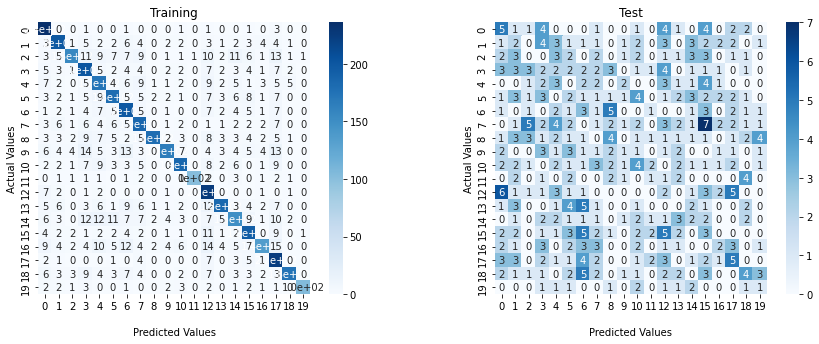

In [ ]:
plt.subplot(1,2,1)
grafico(cm_spectrogram, 'spectrogram.jpg', [i for i in range(20)])
plt.title('Training')
plt.subplot(1,2,2)
grafico(cm_spectrogram_validation, 'spectrogram_validation.jpg', [i for i in range(20)])
plt.title('Test')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

BoltAction22       0.15      0.19      0.17        26
    Colt1911       0.06      0.07      0.07        29
     Glock45       0.00      0.00      0.00        25
     Glock91       0.06      0.06      0.06        32
     Glock92       0.10      0.14      0.11        22
       HKUSP       0.06      0.06      0.06        31
    Kimber45       0.08      0.13      0.10        23
   Lorcin380       0.04      0.03      0.03        39
         M16       0.17      0.14      0.15        29
       MP401       0.09      0.05      0.06        21
       MP402       0.14      0.14      0.14        29
      Rem700       0.09      0.06      0.07        16
     Ruger22       0.05      0.07      0.06        27
    Ruger357       0.00      0.00      0.00        21
        SIG9       0.09      0.09      0.09        22
        SW22       0.07      0.10      0.08        31
      SW38SP       0.13      0.08      0.10        24
    SpKing22       0.18    

#### MFCC

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True, tsize_=197)

100%|██████████| 5197/5197 [02:07<00:00, 40.62it/s]


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = np.array([i.flatten() for i in X_train])
X_test = np.array([i.flatten() for i in X_test])

In [ ]:
pca = PCA(n_components=500)
pca.fit(X_train)

print(sum(pca.explained_variance_ratio_))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

0.8887996549699958


In [ ]:
clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_depth=5, random_state=0, verbose=1)
clf.fit(X_train_pca, y_train)

      Iter       Train Loss   Remaining Time 
         1           2.6891            6.62m
         2           2.5079            6.27m
         3           2.3488            5.89m
         4           2.2252            5.60m
         5           2.1226            5.25m
         6           2.0359            4.89m
         7           1.9656            4.54m
         8           1.8868            4.19m
         9           1.8205            3.84m
        10           1.7638            3.49m
        20           1.3073            0.00s


GradientBoostingClassifier(max_depth=5, n_estimators=20, random_state=0,
                           verbose=1)

In [ ]:
y_pred_train = clf.predict(X_train_pca)
cm_mfcc = confusion_matrix(y_train, y_pred_train)

y_pred = clf.predict(X_test_pca)
cm_mfcc_validation = confusion_matrix(y_test, y_pred)

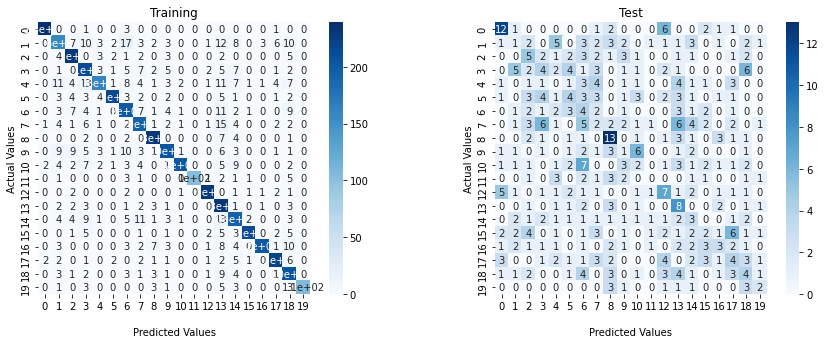

In [ ]:
plt.subplot(1,2,1)
grafico(cm_mfcc, 'mfcc.jpg', [i for i in range(20)])
plt.title('Training')
plt.subplot(1,2,2)
grafico(cm_mfcc_validation, 'mfcc_validation.jpg', [i for i in range(20)])
plt.title('Test')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

BoltAction22       0.41      0.46      0.44        26
    Colt1911       0.05      0.03      0.04        29
     Glock45       0.16      0.20      0.18        25
     Glock91       0.16      0.12      0.14        32
     Glock92       0.00      0.00      0.00        22
       HKUSP       0.17      0.13      0.15        31
    Kimber45       0.09      0.17      0.12        23
   Lorcin380       0.07      0.05      0.06        39
         M16       0.32      0.45      0.37        29
       MP401       0.05      0.05      0.05        21
       MP402       0.10      0.07      0.08        29
      Rem700       0.00      0.00      0.00        16
     Ruger22       0.23      0.26      0.24        27
    Ruger357       0.18      0.38      0.24        21
        SIG9       0.10      0.14      0.12        22
        SW22       0.11      0.06      0.08        31
      SW38SP       0.19      0.12      0.15        24
    SpKing22       0.14    

## CNN

In [ ]:
os.mkdir('img_train')

for s in tqdm(os.listdir('sound_organized/train')):
  cls = s.split('_')[0]
  if cls not in os.listdir('img_train'):
    os.mkdir(f"img_train/{cls}")

  sound_rate, sound_data = wav.read(f'sound_organized/train/{s}')
  spec = feats_mfcc(sound_data, rate=sound_rate, transposed=False)
  cv2.imwrite(f'img_train/{cls}/{s}.jpg', spec)

100%|██████████| 5198/5198 [01:43<00:00, 50.32it/s]


In [ ]:
cv2.imread('img_train/M16/M16_Samsung_SA017AS06.wav.jpg',0).shape

(20, 197)

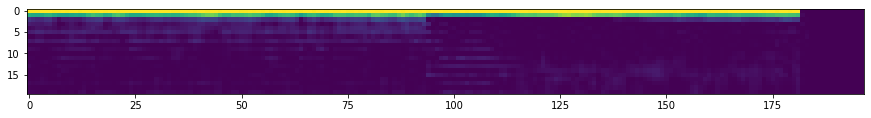

In [ ]:
plt.imshow(cv2.imread('img_train/M16/M16_Samsung_SA017AS02.wav.jpg',0))
plt.show()

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory('img_train',
                                                            image_size=(20,197),
                                                            color_mode='grayscale',
                                                            batch_size=64,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            validation_split=0.2,
                                                            shuffle=True,
                                                            seed=1)

valid_dataset = keras.preprocessing.image_dataset_from_directory('img_train',
                                                            image_size=(20,197),
                                                            color_mode='grayscale',
                                                            batch_size=64,
                                                            label_mode='categorical',
                                                            subset='validation',
                                                            validation_split=0.2,
                                                            shuffle=True,
                                                            seed=1)

Found 5198 files belonging to 20 classes.
Using 4159 files for training.
Found 5198 files belonging to 20 classes.
Using 1039 files for validation.


In [ ]:
num_classes = 20

inputs = keras.Input((20,197,1))

x = inputs
x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.Activation("relu")(x) 
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)


x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.Activation("relu")(x) 
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) 

x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.Activation("relu")(x) 
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) 

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net = keras.Model(inputs, outputs) 


net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.005),
            metrics=['accuracy'])

history = net.fit(train_dataset,
          epochs=100,
          validation_data=valid_dataset);

Epoch 1/100
65/65 [==============================] - 2s 22ms/step - loss: 4.2562 - accuracy: 0.0577 - val_loss: 3.0752 - val_accuracy: 0.0577
Epoch 2/100
65/65 [==============================] - 1s 18ms/step - loss: 2.9835 - accuracy: 0.0796 - val_loss: 2.8264 - val_accuracy: 0.1116
Epoch 3/100
65/65 [==============================] - 1s 19ms/step - loss: 2.8715 - accuracy: 0.0933 - val_loss: 2.8020 - val_accuracy: 0.1011
Epoch 4/100
65/65 [==============================] - 1s 19ms/step - loss: 2.7200 - accuracy: 0.1200 - val_loss: 2.6448 - val_accuracy: 0.1453
Epoch 5/100
65/65 [==============================] - 1s 17ms/step - loss: 2.5434 - accuracy: 0.1652 - val_loss: 2.5271 - val_accuracy: 0.1617
Epoch 6/100
65/65 [==============================] - 1s 17ms/step - loss: 2.4770 - accuracy: 0.1803 - val_loss: 2.4675 - val_accuracy: 0.1838
Epoch 7/100
65/65 [==============================] - 1s 18ms/step - loss: 2.3597 - accuracy: 0.2051 - val_loss: 2.4447 - val_accuracy: 0.1569
Epoch 

In [ ]:
%%capture
labels = np.array([])
pred = np.array([])
for x, y in train_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net.predict(x), axis=-1)])

cf_cnn = confusion_matrix(labels, pred)

labels = np.array([])
pred = np.array([])
for x, y in valid_dataset:
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmax(net.predict(x), axis=-1)])

cf_cnn_valid = confusion_matrix(labels, pred)


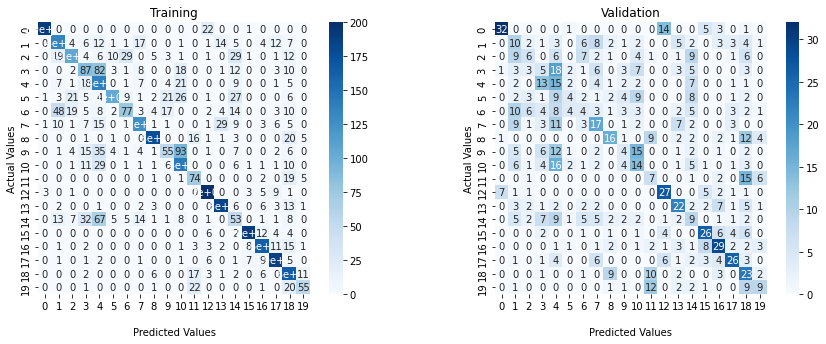

In [ ]:
plt.subplot(1,2,1)
grafico(cf_cnn, 'cnn.png', [i for i in range(20)])
plt.title('Training')
plt.subplot(1,2,2)
grafico(cf_cnn_valid, 'cnn_valid.png', [i for i in range(20)])
plt.title('Validation')
plt.show()

In [ ]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

         0.0       0.78      0.57      0.66        56
         1.0       0.15      0.19      0.17        53
         2.0       0.21      0.11      0.15        53
         3.0       0.10      0.08      0.09        60
         4.0       0.13      0.30      0.18        50
         5.0       0.22      0.08      0.12        48
         6.0       0.12      0.07      0.09        59
         7.0       0.29      0.29      0.29        59
         8.0       0.42      0.32      0.36        50
         9.0       0.15      0.08      0.10        51
        10.0       0.23      0.23      0.23        61
        11.0       0.17      0.22      0.19        32
        12.0       0.51      0.60      0.55        45
        13.0       0.41      0.42      0.42        52
        14.0       0.14      0.16      0.15        56
        15.0       0.51      0.51      0.51        51
        16.0       0.46      0.51      0.48        57
        17.0       0.53    

## GRU

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True, tsize_=197);

100%|██████████| 5197/5197 [02:04<00:00, 41.78it/s]


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_oh = np.array([name_to_number(i) for i in y_train])
y_test_oh = np.array([name_to_number(i) for i in y_test])

In [ ]:
num_classes = 20

n_temp = 197
n_features = 20

inputs = keras.Input((n_temp, n_features))
x = inputs

x = keras.layers.GRU(128, return_sequences=True)(x) 
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.GRU(32, return_sequences=True)(x)
x = keras.layers.GRU(32, return_sequences=False)(x)
x = keras.layers.Dense(32, activation='relu')(x)

x = keras.layers.Dense(num_classes, activation='softmax')(x)

outputs = x

net = keras.Model(inputs, outputs)
net.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 197, 20)]         0         
                                                                 
 gru_10 (GRU)                (None, 197, 128)          57600     
                                                                 
 gru_11 (GRU)                (None, 197, 64)           37248     
                                                                 
 gru_12 (GRU)                (None, 197, 64)           24960     
                                                                 
 gru_13 (GRU)                (None, 197, 32)           9408      
                                                                 
 gru_14 (GRU)                (None, 32)                6336      
                                                                 
 dense_16 (Dense)            (None, 32)                1056

In [ ]:
net.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = 'rmsprop',
            metrics = ['accuracy'])

history = net.fit(X_train,
                  y_train_oh,
                  validation_data = (X_test, y_test_oh),
                  epochs=50)

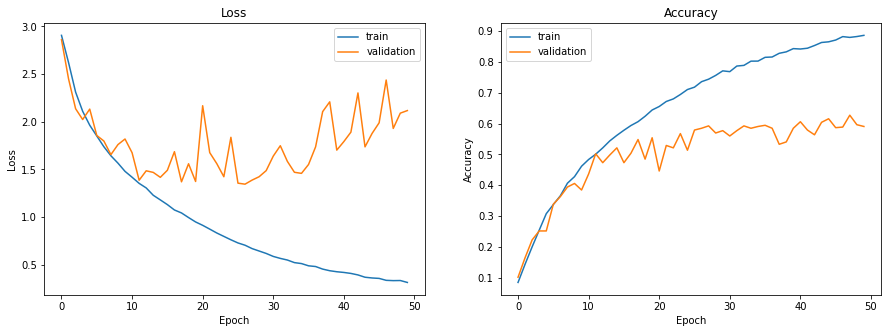

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.title('Accuracy')

plt.savefig('gru_learning_curves.jpg', bbox_inches='tight', pad_inches=0.5)
copyfile('gru_learning_curves.jpg', 'gdrive/My Drive/Data_DigitalSignalsProject/sound_confusion_matrix/gru_learning_curves.jpg')

plt.show()

In [ ]:
pred = net.predict(X_train)
y_train_pred = np.array([np.argmax(i) for i in pred])

pred = net.predict(X_test)
y_test_pred = np.array([np.argmax(i) for i in pred])

cf_matrix_train = confusion_matrix(y_train_oh, y_train_pred)
cf_matrix_test = confusion_matrix(y_test_oh, y_test_pred)

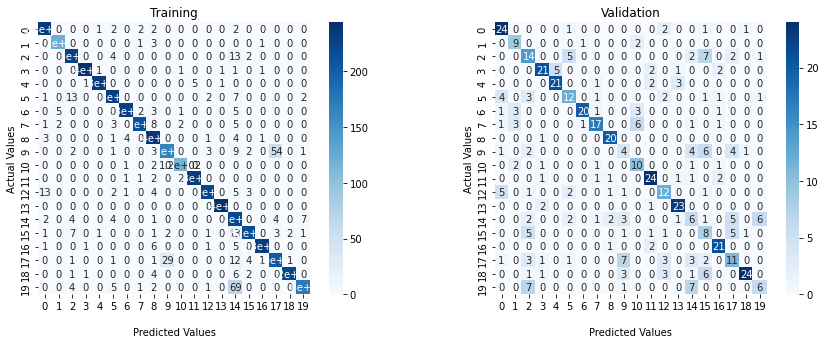

In [ ]:
plt.subplot(1,2,1)
grafico(cf_matrix_train, 'train_cf_GRU.jpg', [i for i in range(20)])
plt.title('Training')
plt.subplot(1,2,2)
grafico(cf_matrix_test, 'test_cf_GRU.jpg', [i for i in range(20)])
plt.title('Validation')
plt.show()

In [ ]:
print(classification_report(y_test_oh, y_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.83      0.73        29
           1       0.53      0.75      0.62        12
           2       0.37      0.45      0.41        31
           3       0.75      0.68      0.71        31
           4       0.81      0.78      0.79        27
           5       0.52      0.48      0.50        25
           6       0.91      0.69      0.78        29
           7       0.74      0.57      0.64        30
           8       0.80      0.95      0.87        21
           9       0.20      0.18      0.19        22
          10       0.48      0.62      0.54        16
          11       0.75      0.77      0.76        31
          12       0.52      0.52      0.52        23
          13       0.79      0.88      0.84        26
          14       0.23      0.21      0.22        29
          15       0.24      0.36      0.29        22
          16       0.72      0.88      0.79        24
          17       0.41    

# **TEST**

In [12]:
def load_all_data(feature_extractor=feats_spectrogram, normalize=False, ts=0.1, tsize_=10):

    labels = []
    features = []

    for f in tqdm(os.listdir('sound_organized/train')):
        if f.endswith('.wav'):
            signal_rate, signal = wav.read('sound_organized/train/' + f)
            cur_features = feature_extractor(signal, rate = signal_rate, tsize=tsize_)
            features.append(cur_features)
            label = f.split('_')[0]
            labels.append(label)

    X_train = features
    y_train = labels

    labels = []
    features = []

    for f in tqdm(os.listdir('sound_organized/test')):
        if f.endswith('.wav'):
            signal_rate, signal = wav.read('sound_organized/test/' + f)
            cur_features = feature_extractor(signal, rate = signal_rate, tsize=tsize_)
            features.append(cur_features)
            label = f.split('_')[0]
            labels.append(label)

    X_test = features
    y_test = labels

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]
        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [34]:
X_train, X_test, y_train, y_test = load_all_data(feature_extractor=feats_mfcc, normalize=False, tsize_=197);

100%|██████████| 1315/1315 [00:29<00:00, 45.13it/s]


In [36]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_oh = np.array([name_to_number(i) for i in y_train])
y_test_oh = np.array([name_to_number(i) for i in y_test])

In [37]:
num_classes = 20

n_temp = 197
n_features = 20

inputs = keras.Input((n_temp, n_features))
x = inputs

x = keras.layers.GRU(128, return_sequences=True)(x) 
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.GRU(32, return_sequences=True)(x)
x = keras.layers.GRU(32, return_sequences=False)(x)

x = keras.layers.Dense(32, activation='relu')(x)

x = keras.layers.Dense(num_classes, activation='softmax')(x)

outputs = x

net = keras.Model(inputs, outputs)
net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 197, 20)]         0         
                                                                 
 gru_5 (GRU)                 (None, 197, 128)          57600     
                                                                 
 gru_6 (GRU)                 (None, 197, 64)           37248     
                                                                 
 gru_7 (GRU)                 (None, 197, 64)           24960     
                                                                 
 gru_8 (GRU)                 (None, 197, 32)           9408      
                                                                 
 gru_9 (GRU)                 (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 32)                1056

In [39]:
net.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = 'rmsprop',
            metrics = ['accuracy'])

history = net.fit(X_train,
                  y_train_oh,
                  validation_data = (X_test, y_test_oh),
                  epochs=30)

Epoch 1/30
163/163 [==============================] - 16s 47ms/step - loss: 2.9241 - accuracy: 0.0793 - val_loss: 2.8347 - val_accuracy: 0.1011
Epoch 2/30
163/163 [==============================] - 7s 42ms/step - loss: 2.6970 - accuracy: 0.1197 - val_loss: 2.6274 - val_accuracy: 0.1361
Epoch 3/30
163/163 [==============================] - 6s 38ms/step - loss: 2.5167 - accuracy: 0.1584 - val_loss: 2.5091 - val_accuracy: 0.1665
Epoch 4/30
163/163 [==============================] - 6s 39ms/step - loss: 2.3502 - accuracy: 0.1922 - val_loss: 2.2606 - val_accuracy: 0.1947
Epoch 5/30
163/163 [==============================] - 6s 38ms/step - loss: 2.2352 - accuracy: 0.2149 - val_loss: 2.1915 - val_accuracy: 0.2106
Epoch 6/30
163/163 [==============================] - 6s 38ms/step - loss: 2.1370 - accuracy: 0.2509 - val_loss: 2.0945 - val_accuracy: 0.2570
Epoch 7/30
163/163 [==============================] - 6s 38ms/step - loss: 2.0556 - accuracy: 0.2794 - val_loss: 2.0854 - val_accuracy: 0.287

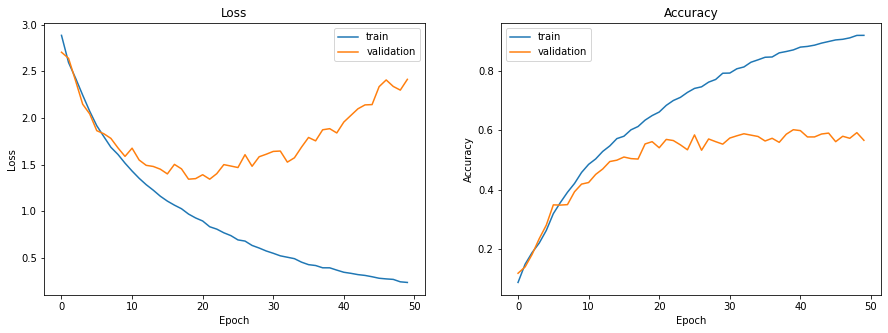

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.title('Accuracy')

plt.savefig('gru_learning_curves_FINAL.jpg', bbox_inches='tight', pad_inches=0.5)
copyfile('gru_learning_curves_FINAL.jpg', 'gdrive/My Drive/Data_DigitalSignalsProject/sound_confusion_matrix/gru_learning_curves_FINAL.jpg')

plt.show()

In [ ]:
pred = net.predict(X_train)
y_train_pred = np.array([np.argmax(i) for i in pred])

pred = net.predict(X_test)
y_test_pred = np.array([np.argmax(i) for i in pred])

cf_matrix_train = confusion_matrix(y_train_oh, y_train_pred)
cf_matrix_test = confusion_matrix(y_test_oh, y_test_pred)

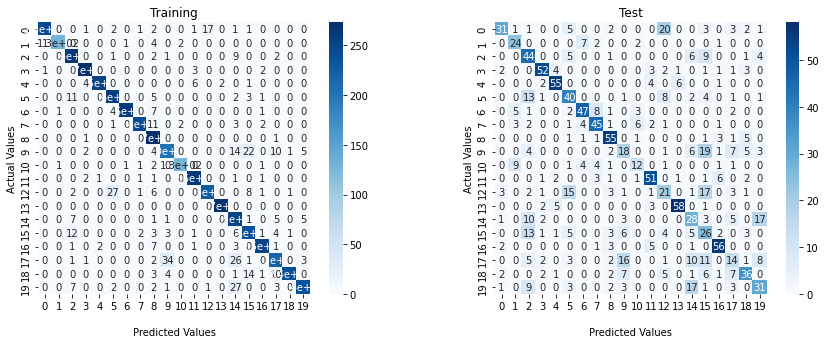

In [ ]:
plt.subplot(1,2,1)
grafico(cf_matrix_train, 'train_cf_GRU_FINAL.jpg', [i for i in range(20)])
plt.title('Training')
plt.subplot(1,2,2)
grafico(cf_matrix_test, 'test_cf_GRU_FINAL.jpg', [i for i in range(20)])
plt.title('Test')
plt.show()

In [ ]:
print(classification_report(y_test_oh, y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.45      0.56        69
           1       0.57      0.67      0.62        36
           2       0.42      0.63      0.51        70
           3       0.79      0.74      0.76        70
           4       0.81      0.81      0.81        68
           5       0.49      0.56      0.53        71
           6       0.75      0.68      0.71        69
           7       0.70      0.68      0.69        66
           8       0.70      0.80      0.74        69
           9       0.33      0.27      0.30        66
          10       0.48      0.35      0.41        34
          11       0.74      0.74      0.74        69
          12       0.33      0.30      0.32        69
          13       0.88      0.84      0.86        69
          14       0.36      0.41      0.38        69
          15       0.25      0.38      0.30        69
          16       0.76      0.82      0.79        68
          17       0.29    

In [64]:
joblib.dump(net, 'sound_classifier_model.sav')
copyfile('sound_classifier_model.sav', f'gdrive/MyDrive/Data_DigitalSignalsProject/sound_classifier_model_aaa.sav')


'gdrive/MyDrive/Data_DigitalSignalsProject/sound_classifier_model_aaa.sav'

In [53]:
sound_rate, sound_data = wav.read('sound_organized/test/MP401_Samsung_SA011AS04.wav')
features = np.expand_dims(feats_mfcc(sound_data, rate=sound_rate), 0)
np.argmax(net.predict(features))

1/1 [==============================] - 0s 63ms/step


19

In [54]:
sound_rate, sound_data = wav.read('sound_organized/test/Ruger22_Samsung_SA083AS02.wav')
features = np.expand_dims(feats_mfcc(sound_data, rate=sound_rate), 0)
np.argmax(net.predict(features))

1/1 [==============================] - 0s 121ms/step


4

In [60]:
sound_rate, sound_data = wav.read('sound_organized/test/Ruger357_Samsung_SA147BS03.wav')
features = np.expand_dims(feats_mfcc(sound_data, rate=sound_rate), 0)
np.argmax(net.predict(features))

1/1 [==============================] - 0s 38ms/step


8

In [63]:
sound_rate, sound_data = wav.read('sound_organized/test/Glock45_iPhone_IP074AS06.wav')
features = np.expand_dims(feats_mfcc(sound_data, rate=sound_rate), 0)
np.argmax(net.predict(features))

1/1 [==============================] - 0s 84ms/step


5

## TOP-3 SCORES

In [ ]:
pred = net.predict(X_train)
y_train_pred = np.array([np.argsort(i)[-3:] for i in pred])

pred = net.predict(X_test)
y_test_pred = np.array([np.argsort(i)[-3:] for i in pred])

42/42 [==============================] - 1s 21ms/step


In [ ]:
correct = 0
total = 0

for i in range(len(y_train_oh)):
  if y_train_oh[i] in y_train_pred[i]:
    correct = correct + 1
  total = total + 1

print(f"Train accuracy: {round((correct/total)*100,1)} %")

Train accuracy: 97.8 %


In [ ]:
correct = 0
total = 0

for i in range(len(y_test_oh)):
  if y_test_oh[i] in y_test_pred[i]:
    correct = correct + 1
  total = total + 1

print(f"Test accuracy: {round((correct/total)*100,1)} %")

Test accuracy: 81.5 %
